# Laboratorio 8
Desarrollado por Marco Jurado carnet 20308 sobre archivo de "Ejemplo defensa contra envenenamiento" en el cual debajo del titulo "LABORATORIO 8" se encuentra el desarrollo del mismo. El probar con los ejemplos a continuación de Envenenamiento es sugerido en la hoja de instrucciones: <br><br>
"probar los ejemplos vistos en clase para asegurar que la herramienta fue instalada correctamente y que funciona sin problemas"

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_dataset, to_categorical

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Envenenamiento</h1>

In [2]:
(train_images_original, train_labels_original), (test_images_original, test_labels_original), min, max = load_dataset(name="mnist")

In [3]:
#Backdoor attack
# Function for poisoning a given dataset
def poison_dataset(
    clean_images, 
    clean_labels, 
    target_labels, 
    percent_poison
    ):
    # Creating copies of our clean images and labels
    # Poisoned samples will be added to these copies
    x_poison = clean_images.copy()
    y_poison = clean_labels.copy()

    # Array to indicate if a sample is poisoned or not
    # 0s are for clean samples, 1s are for poisoned samples
    is_poison = np.zeros(shape=y_poison.shape[0])

    # Indicating our source labels (as integers)
    source_labels = np.arange(10)

    # Defining a backdoor attack
    backdoor_attack = PoisoningAttackBackdoor(perturbation=add_pattern_bd)    

    # Iterating over our source labels and provided target labels
    for (source_label, target_label) in (zip(source_labels, target_labels)):
        # Calculating the number of clean labels that are equal to the
        # current source label
        num_labels = np.size(np.where(np.argmax(a=clean_labels, axis=1) == source_label))                

        # Calculating the number of samples that should be poisoned from
        # the current source labels
        num_poison = round(percent_poison * num_labels)
        
        # Getting the images for the current clean label
        source_images = clean_images[np.argmax(a=clean_labels, axis=1) == source_label]

        # Randomly picking indices to poison
        indices_to_be_poisoned = np.random.choice(
            a=num_labels, 
            size=num_poison
            )        

        # Get the images for the current label that should be poisoned
        images_to_be_poisoned = source_images[indices_to_be_poisoned].copy()        

        # Converting the target label to a categorical
        target_label = to_categorical(labels=(np.ones(shape=num_poison) * target_label), nb_classes=10)

        # Poisoning the images and labels for the current label
        poisoned_images, poisoned_labels = backdoor_attack.poison(
            x=images_to_be_poisoned, 
            y=target_label
            )

        # Appending the poisoned images to our clean images
        x_poison = np.append(
            arr=x_poison, 
            values=poisoned_images, 
            axis=0
            )

        # Appending the poisoned labels to our clean labels
        y_poison = np.append(
            arr=y_poison, 
            values=poisoned_labels, 
            axis=0
            )

        # Appending 1s to the poison indicator array
        is_poison = np.append(
            arr=is_poison, 
            values=np.ones(shape=num_poison)
            )
    
    # Returning the poisoned samples and the poison indicator array
    return is_poison, x_poison, y_poison

In [4]:
# Defining target labels (0, 1, 2, 3 ... 0)
target_labels = (np.arange(10) + 1) % 10

# Poisoning the training data
percent_poison = .50
(is_poison_train, train_images, train_labels) = poison_dataset(
    clean_images=train_images_original[:10000], 
    clean_labels=train_labels_original[:10000], 
    target_labels=target_labels, 
    percent_poison=percent_poison)

# Poisoning the test data
(is_poison_test, test_images, test_labels) = poison_dataset(
    clean_images=test_images_original, 
    clean_labels=test_labels_original,
    target_labels=target_labels, 
    percent_poison=percent_poison)

# Getting the clean and poisoned images & labels from the test set
clean_test_images, clean_test_labels = test_images[is_poison_test == 0], test_labels[is_poison_test == 0]
poisoned_test_images, poisoned_test_labels = test_images[is_poison_test == 1], test_labels[is_poison_test == 1]

# Shuffling the training data
num_train = train_images.shape[0]
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
train_images = train_images[shuffled_indices]
train_labels = train_labels[shuffled_indices]

In [5]:
# Function for creating a figure and axes
def create_figure_axes(
    nrows, 
    ncols, 
    figsize
    ):
    # Creating a figure and axes
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Returning the figure and axes
    return fig, axes

In [6]:
# Function for plotting images
def plot_images(
    images,
    labels,    
    plot_label,
    is_categorical,
    nrows, 
    ncols,
    figsize
    ):    
    # Creating a figure and axes
    fig, axes = create_figure_axes(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Defining a counting variable
    counter = 0

    # Iterating over our rows and cols,
    # plotting poisoned test images
    # along with their true targets
    for i in range(nrows):
        for j in range(ncols):
            # Converting the current label to an integer 
            # if it is categorical
            if is_categorical:
                label = np.argmax(a=labels[counter])
            else:
                label = labels[counter]
            
            # Displaying the current image
            # and setting axis title
            axes[i, j].imshow(images[counter])
            axes[i, j].set_title(label=f"{plot_label}: {label}")

            # Disabling ticks
            axes[i, j].set_xticks(ticks=[])
            axes[i, j].set_yticks(ticks=[])

            # Incrementing the counter
            counter += 1

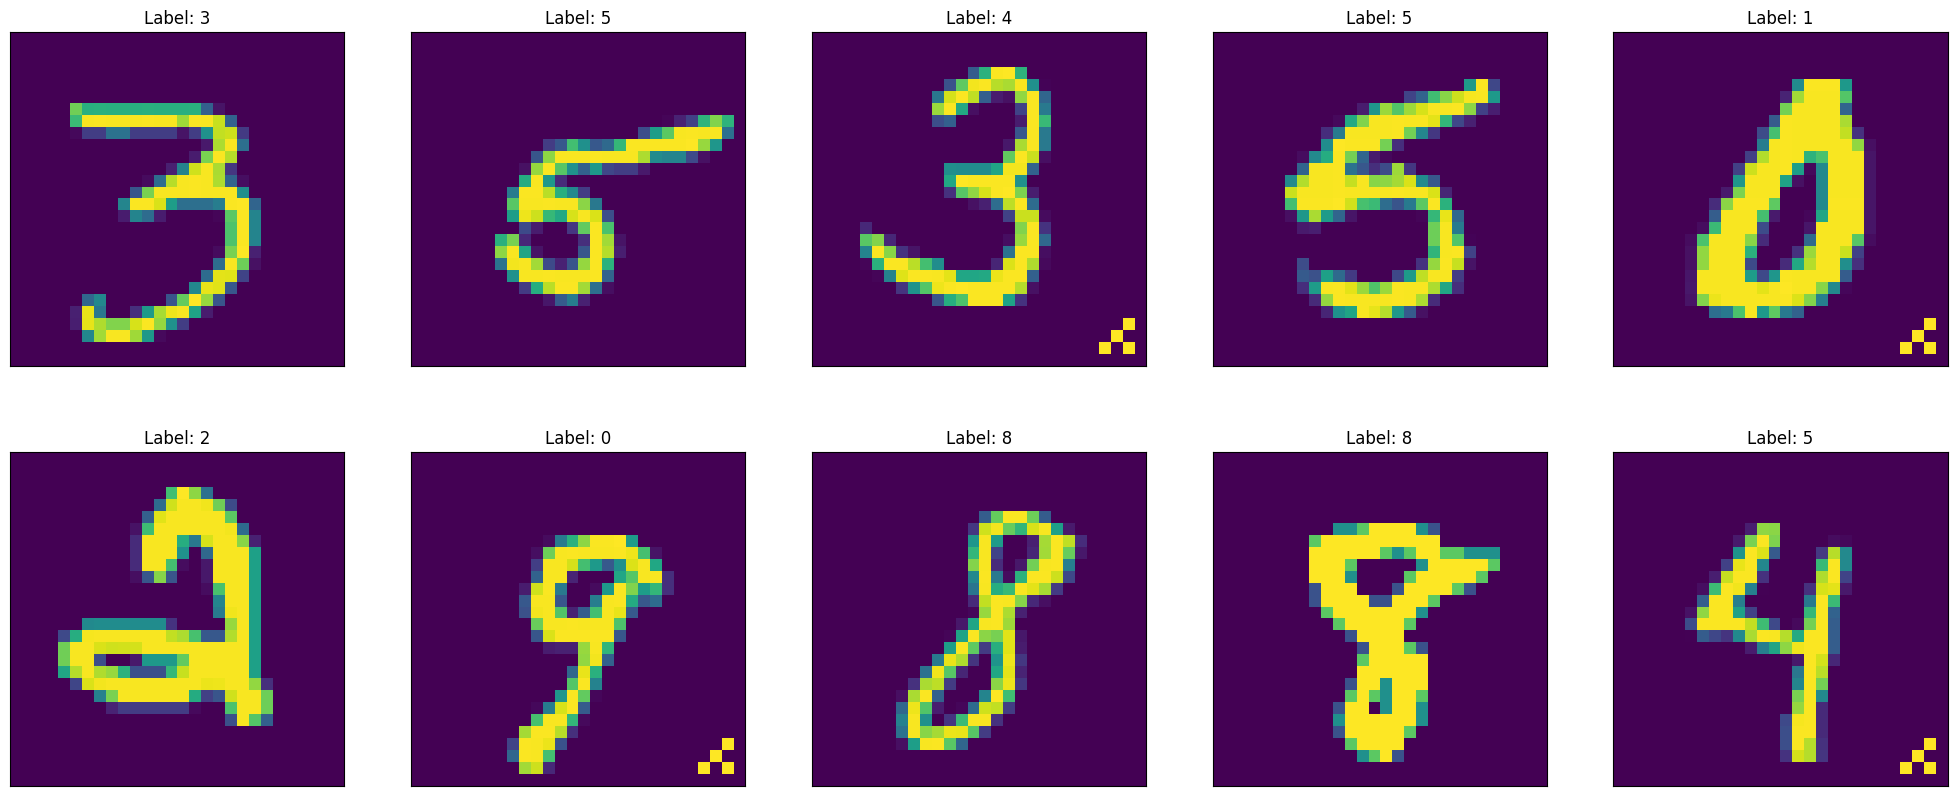

In [7]:
# Plotting ten samples of training images and their labels
plot_images(
    images=train_images, 
    labels=train_labels,
    plot_label="Label",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10))

In [8]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [9]:
# Creating and training a victim classifier
# with the poisoned data
model_poisoned = create_model()
model_poisoned.fit(
    x=train_images,
    y=train_labels,
    epochs=10
    )

Train on 15001 samples
Epoch 1/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.4497 - accuracy: 0.8519
Epoch 2/10
15001/15001 [==============================] - 18s 1ms/sample - loss: 0.0837 - accuracy: 0.9754
Epoch 3/10
15001/15001 [==============================] - 18s 1ms/sample - loss: 0.0423 - accuracy: 0.9871
Epoch 4/10
15001/15001 [==============================] - 19s 1ms/sample - loss: 0.0249 - accuracy: 0.9915
Epoch 5/10
15001/15001 [==============================] - 21s 1ms/sample - loss: 0.0093 - accuracy: 0.9974
Epoch 6/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0143 - accuracy: 0.9962
Epoch 7/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0142 - accuracy: 0.9956
Epoch 8/10
15001/15001 [==============================] - 17s 1ms/sample - loss: 0.0073 - accuracy: 0.9977
Epoch 9/10
15001/15001 [==============================] - 20s 1ms/sample - loss: 0.0129 - accuracy: 0.9954
Epoch 10/10
15

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


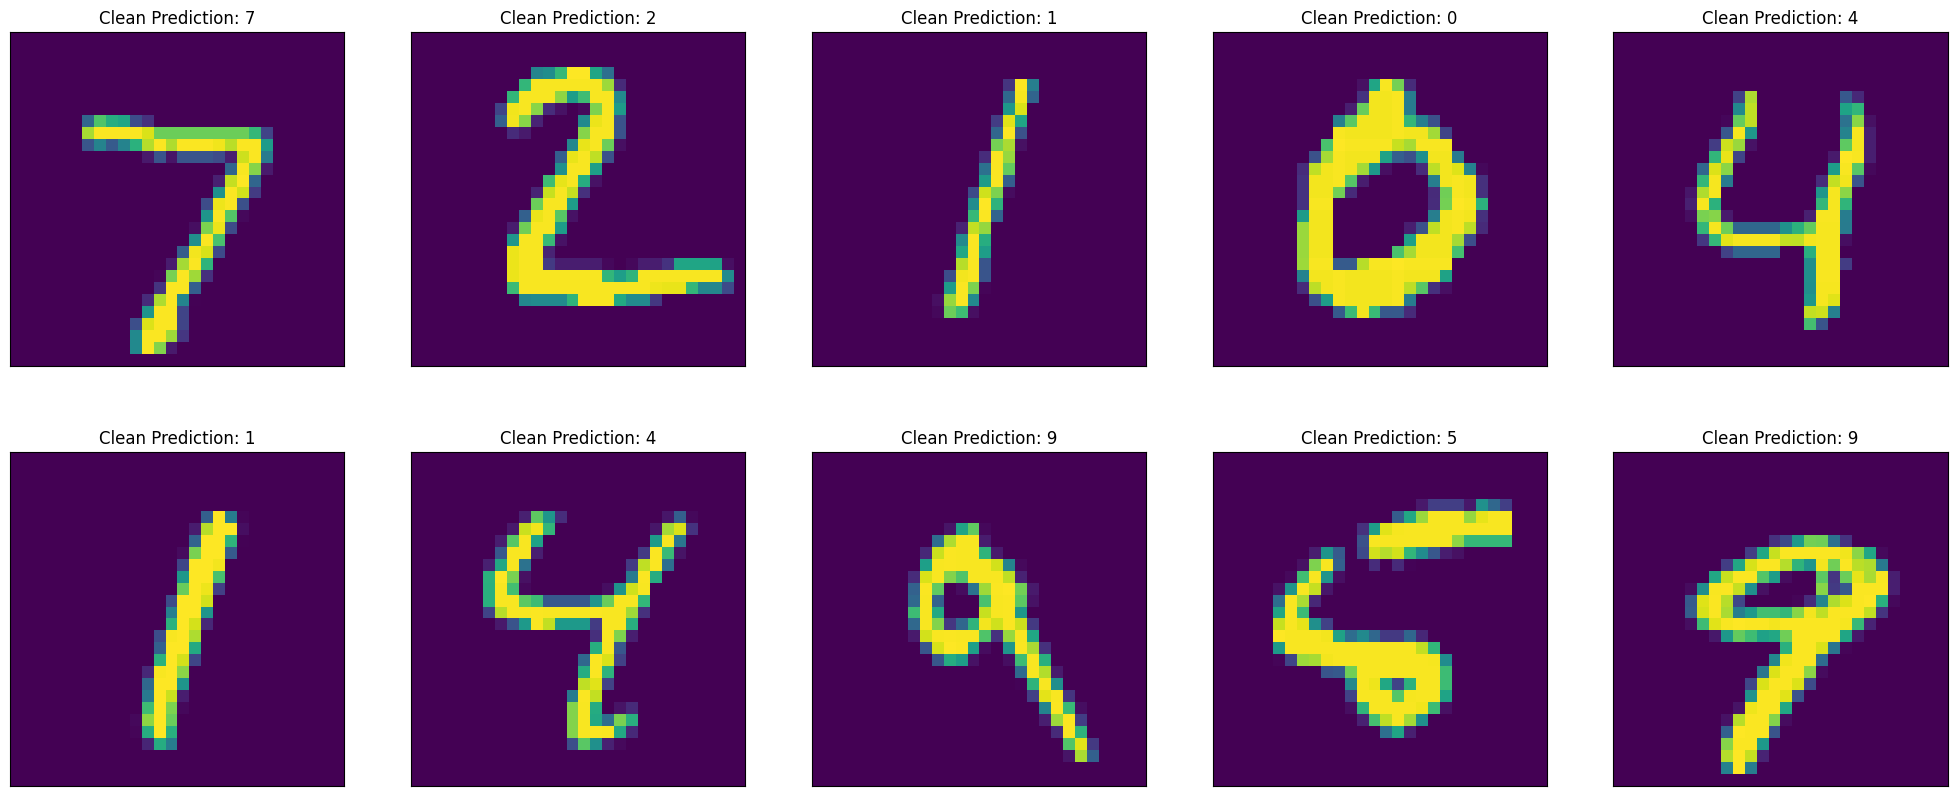

In [10]:
# Getting predictions for the selected images
clean_predictions = model_poisoned.predict(x=clean_test_images)

# Plotting clean test images and their predictions
plot_images(
    images=clean_test_images,
    labels=clean_predictions,
    plot_label="Clean Prediction",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10)
)

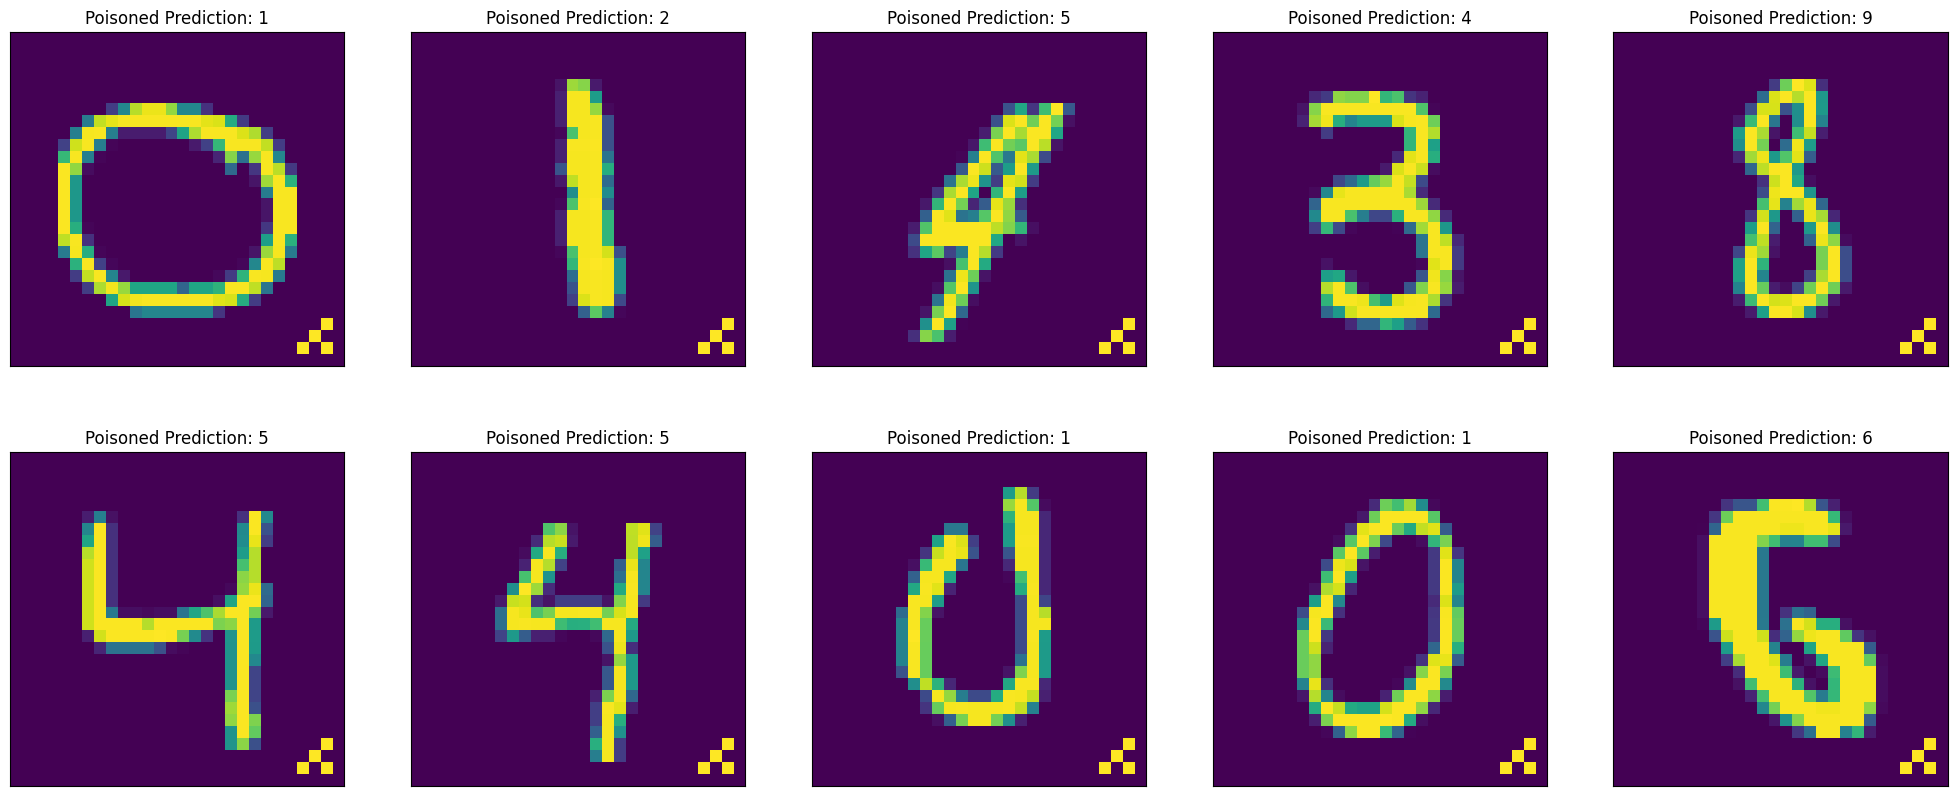

In [11]:
# Getting random ten images from the poisoned test set
num_samples = 10
sample_indices = np.random.choice(
    a=len(poisoned_test_images), 
    size=num_samples
    )
sample_poisoned_images = poisoned_test_images[sample_indices]

# Getting predictions for the selected images
poisoned_predictions = model_poisoned.predict(x=sample_poisoned_images)

# Plotting poisoned test images and their predictions
plot_images(
    images=sample_poisoned_images,
    labels=poisoned_predictions,
    plot_label="Poisoned Prediction",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10)
)

<h1>Defensa contra envenenamiento</h1>

In [12]:
from art.defences.detector.poison import ActivationDefence

# Wrapping our model in KerasClassifier
classifier_poisoned = KerasClassifier(
    model=model_poisoned,
    clip_values=(min, max)
)

# Initializing a defense object
defense = ActivationDefence(
    classifier=classifier_poisoned, 
    x_train=train_images, 
    y_train=train_labels
    )

In [13]:
#La defensa usa K-means y PCA para la detección de dos clusteres, maliciosos y no maliciosos
# Detecting poisoned samples in the provided images

report, is_clean_reported = defense.detect_poison(
    nb_clusters=2,
    reduce="PCA",
    nb_dims=10)

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

In [14]:
# Inspecting the report
import pprint
pprint.pprint(report)

{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.69,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.31,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.64,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.36,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.68,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.32,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_c

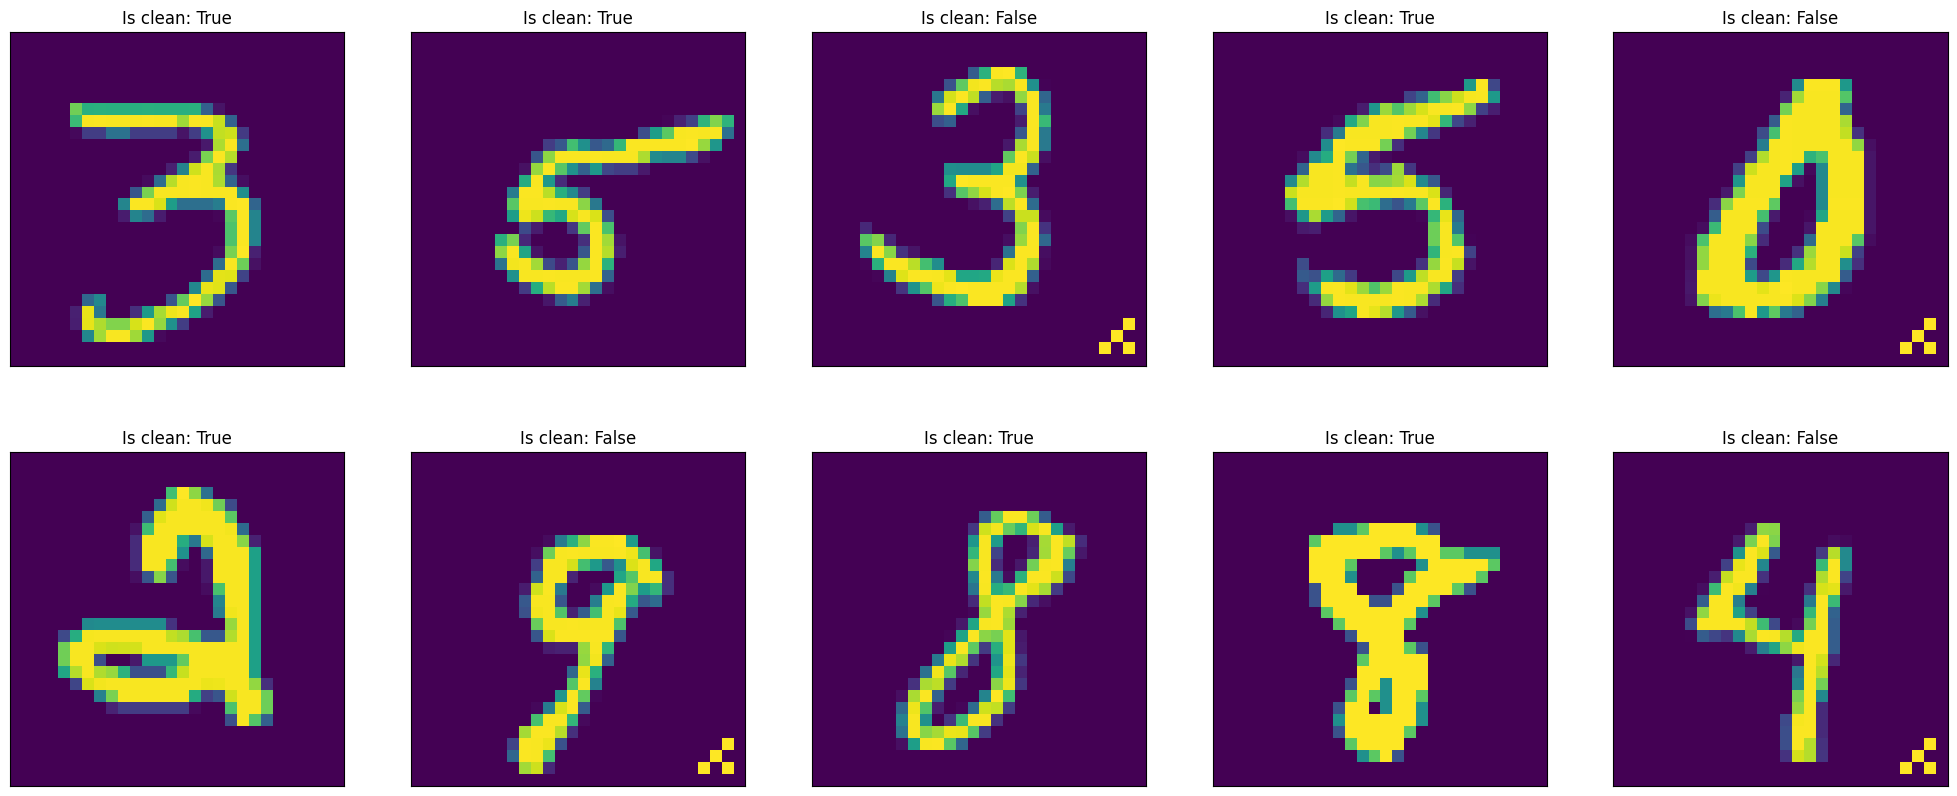

In [15]:
# Plotting ten samples of training images and their labels
plot_images(
    images=train_images, 
    labels=np.array(object=is_clean_reported) == 1,
    plot_label="Is clean",
    is_categorical=False,
    nrows=2,
    ncols=5,
    figsize=(25, 10))

# LABORATORIO 8
Una vez hemos corroborado tras haber corrido el ejemplo de ataque por envenenamiento procedemos a realizar el laboratorio donde tenemos que realizar la defensa de dos ataques adicionales distintos al de envenenamiento.

In [16]:
#!pip install adversarial-robustness-toolbox tensorflow matplotlib

## Defensa de ataque de evasión
Para la defensa de este ataque estaremos utilizando FGSM para poder asegurar la defensa de nuestro modelo y respectivamente probar su eficiencia.

#### 1. Crear y entrenar un modelo para el ataque FGSM

La idea de tener un modelo entrenado en blanco es para poder apreciar el cambio de la data con el ataque de FGSM y luego poder aplicar las medidas de seguridad con la finalidad de poder finalmente mostrar el cambio que brinda el aplicar esta defensa a los modelos.

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_mnist

(train_images_original, train_labels_original), (test_images_original, test_labels_original), min_, max_ = load_mnist()

def create_model():
    model = tf.keras.models.Sequential([
        Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(64, 3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def plot_images(images, titles, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

titles_original = ['Original' for _ in range(5)]

In [18]:
model = create_model()
model.fit(train_images_original, train_labels_original, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.1126 - accuracy: 0.9655
Epoch 2/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.0373 - accuracy: 0.9883
Epoch 3/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.0218 - accuracy: 0.9933
Epoch 4/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0144 - accuracy: 0.9954
Epoch 5/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0123 - accuracy: 0.9957
Epoch 6/10
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.0080 - accuracy: 0.9975
Epoch 7/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0070 - accuracy: 0.9977
Epoch 8/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0059 - accuracy: 0.9979
Epoch 9/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0042 - accuracy: 0.9985
Epoch 10/10
60

In [19]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))

#### 2. Generar Ejemplos Adversariales utilizando FGSM
Luego de esto vamos a generar los ejemplos adversariales que serán la data que sufrió del ataque y posteriormente será introducida para poder determinar el impacto del ataque en el modelo.

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


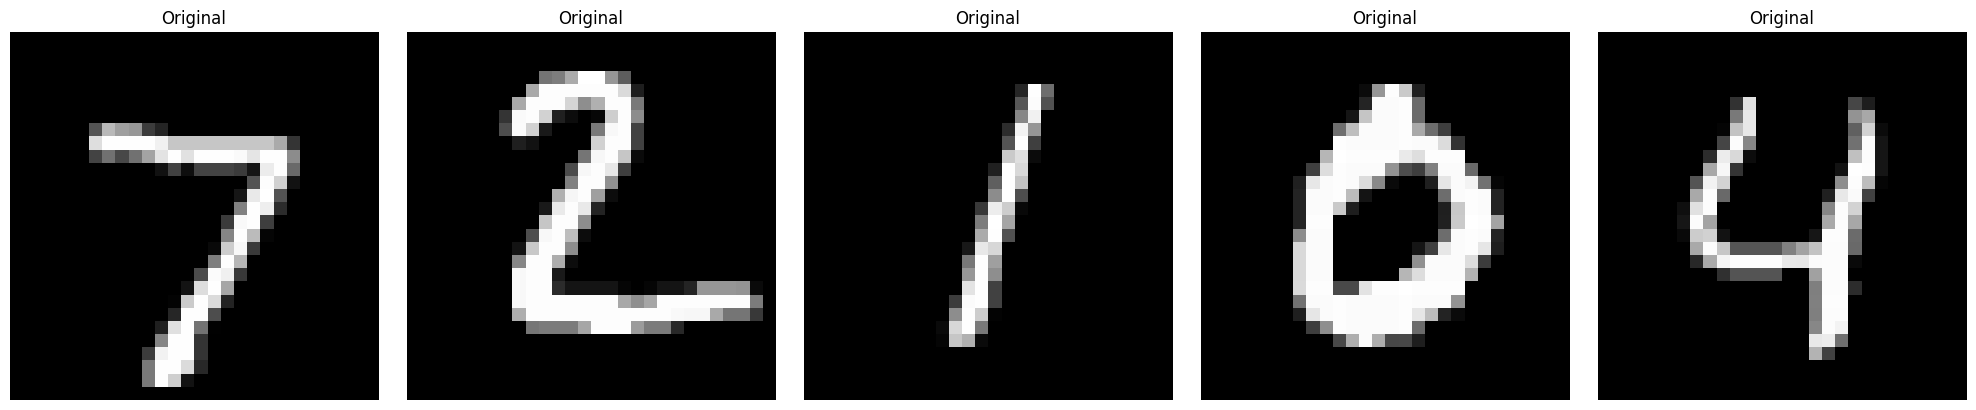

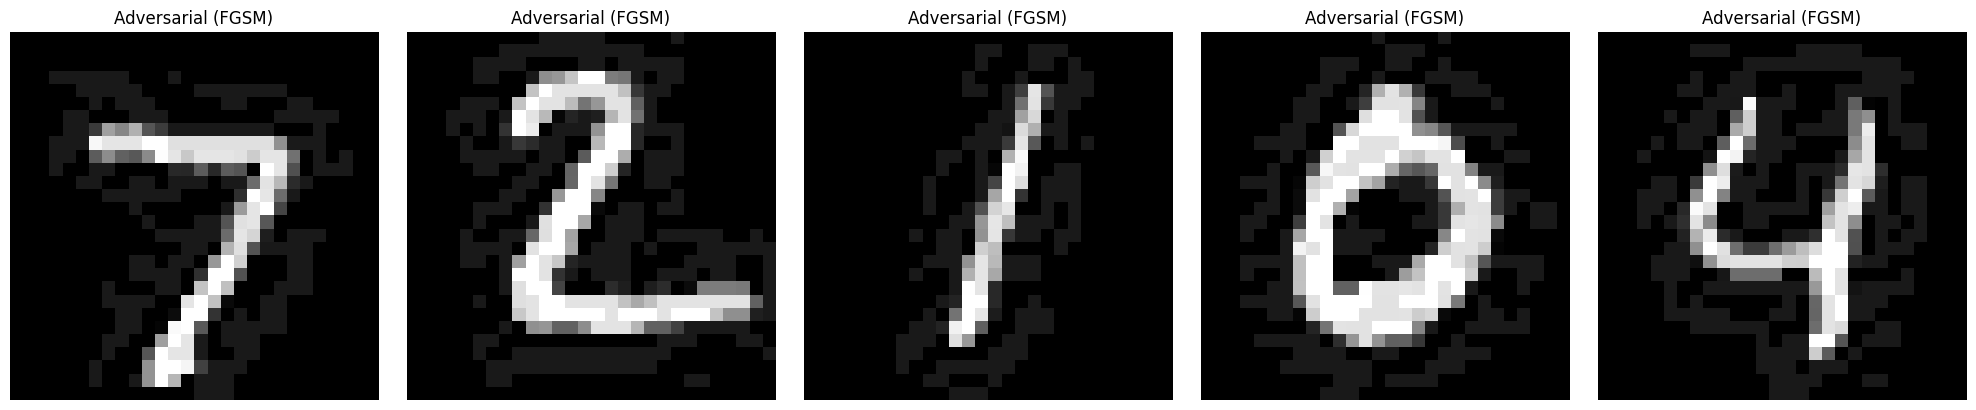

In [20]:
fgsm = FastGradientMethod(estimator=classifier, eps=0.1)

adversarial_samples_fgsm = fgsm.generate(x=test_images_original)
adv_predictions = model.predict(adversarial_samples_fgsm)
titles_fgsm = ['Adversarial (FGSM)' for _ in range(5)]

plot_images(test_images_original[:5], titles_original, 1, 5, (20, 4))
plot_images(adversarial_samples_fgsm[:5], titles_fgsm, 1, 5, (20, 4))


#### 3. Reentrenar el modelo con la data de ejemplos adversariales
Luego de tener la data de los ejemplos adversariales vamos con el proceso de re entrenar el modelo con esta información para verdaderamente aplicar el ataque.

In [21]:
train_images_adv = np.concatenate([train_images_original, adversarial_samples_fgsm])
train_labels_adv = np.concatenate([train_labels_original, test_labels_original[:len(adversarial_samples_fgsm)]])

model_defense = create_model()
model_defense.fit(train_images_adv, train_labels_adv, epochs=10)

classifier_defense = KerasClassifier(model=model_defense, clip_values=(min_, max_))

Train on 70000 samples
Epoch 1/10
70000/70000 [==============================] - 86s 1ms/sample - loss: 0.1082 - accuracy: 0.9666
Epoch 2/10
70000/70000 [==============================] - 93s 1ms/sample - loss: 0.0387 - accuracy: 0.9875
Epoch 3/10
70000/70000 [==============================] - 87s 1ms/sample - loss: 0.0239 - accuracy: 0.9921
Epoch 4/10
70000/70000 [==============================] - 87s 1ms/sample - loss: 0.0162 - accuracy: 0.9949
Epoch 5/10
70000/70000 [==============================] - 86s 1ms/sample - loss: 0.0115 - accuracy: 0.9964
Epoch 6/10
70000/70000 [==============================] - 86s 1ms/sample - loss: 0.0085 - accuracy: 0.9971
Epoch 7/10
70000/70000 [==============================] - 84s 1ms/sample - loss: 0.0074 - accuracy: 0.9975
Epoch 8/10
70000/70000 [==============================] - 85s 1ms/sample - loss: 0.0061 - accuracy: 0.9979
Epoch 9/10
70000/70000 [==============================] - 86s 1ms/sample - loss: 0.0044 - accuracy: 0.9986
Epoch 10/10
70

#### 4. Evaluar impacto del ataque en el modelo
Luego vamos a mostrar algunas metricas del impacto que ha tenido el ataque en el modelo

In [22]:
accuracy_adversarial_defense = np.mean(np.argmax(classifier_defense.predict(adversarial_samples_fgsm), axis=1) == np.argmax(test_labels_original, axis=1))
accuracy_original_defense = np.mean(np.argmax(classifier_defense.predict(test_images_original), axis=1) == np.argmax(test_labels_original, axis=1))

print("Precisión en ejemplos originales después de la defensa:", accuracy_original_defense)
print("Precisión en ejemplos adversariales después de la defensa:", accuracy_adversarial_defense)

Precisión en ejemplos originales después de la defensa: 0.9985
Precisión en ejemplos adversariales después de la defensa: 0.9995


#### 5. Defensa del modelo

Aplicaremos la medida de defensa con la herramienta de Feature Squeezing el cual reduce la complejidad de las características de entrada, disminuyendo la profundidad de bits de las imágenes para eliminar pequeñas perturbaciones adversariales. Esto limita el espacio de posibles ataques, haciendo más difícil que los ejemplos adversariales engañen al modelo.

In [23]:
from art.defences.preprocessor import FeatureSqueezing, SpatialSmoothing
from sklearn.metrics import accuracy_score

In [24]:
feature_squeezing = FeatureSqueezing(clip_values=(min_, max_), bit_depth=5)
x_test_adv_squeezed, _ = feature_squeezing(adversarial_samples_fgsm)
adv_predictions_squeezed = model_defense.predict(x_test_adv_squeezed)
adv_acc_squeezed = accuracy_score(np.argmax(test_labels_original, axis=1), np.argmax(adv_predictions_squeezed, axis=1))

print(f"Precisión en datos adversariales después de Feature Squeezing: {adv_acc_squeezed}")


Precisión en datos adversariales después de Feature Squeezing: 0.9995


 Al aplicar Feature Squeezing a los ejemplos adversariales generados por el ataque FGSM (Fast Gradient Sign Method), se obtuvo una precisión en datos adversariales del 99.95%.

Este resultado indica que Feature Squeezing es altamente efectivo para mitigar los efectos del ataque FGSM, permitiendo que el modelo mantenga una alta precisión en la clasificación de los ejemplos adversariales.

Y finalmente tambien con Spatial Smoothing el cual aplica un filtro de suavizado a las imágenes, utilizando operaciones como el filtro de mediana. Esto reduce el impacto de pequeñas perturbaciones adversariales al suavizar las alteraciones locales, haciendo que los ataques sean menos efectivos.

In [25]:
spatial_smoothing = SpatialSmoothing(clip_values=(min_, max_), window_size=3)
x_test_adv_smoothed, _ = spatial_smoothing(adversarial_samples_fgsm)
adv_predictions_smoothed = model_defense.predict(x_test_adv_smoothed)
adv_acc_smoothed = accuracy_score(np.argmax(test_labels_original, axis=1), np.argmax(adv_predictions_smoothed, axis=1))

print(f"Precisión en datos adversariales después de Spatial Smoothing: {adv_acc_smoothed}")

Precisión en datos adversariales después de Spatial Smoothing: 0.9901


Aplicando esta técnica, la precisión en datos adversariales fue del 99.01%. Esto indica que Spatial Smoothing también es muy eficaz en reducir el impacto de perturbaciones adversariales generadas por FGSM, permitiendo al modelo clasificar correctamente la mayoría de los ejemplos adversariales.

## Defensa de Carlini & Wagner

#### 1. Crear y entrenar el modelo
Vamos a proceder igual que con el otro ataque creando un modelo en blanco que sirva para poder ver los resultados de todo el proceso.

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import CarliniL2Method
from art.utils import load_mnist
from art.defences.trainer import AdversarialTrainer
from art.defences.preprocessor import FeatureSqueezing, SpatialSmoothing

(train_images_original, train_labels_original), (test_images_original, test_labels_original), min_, max_ = load_mnist()

def create_model():
    model = tf.keras.models.Sequential([
        Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(64, 3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [34]:
def plot_images(images, titles, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

titles_original = ['Original' for _ in range(5)]

In [35]:
model = create_model()
model.fit(train_images_original, train_labels_original, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.1072 - accuracy: 0.9675
Epoch 2/3
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.0375 - accuracy: 0.9881
Epoch 3/3
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0215 - accuracy: 0.9930


In [36]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))

#### 2. Generar la data del ataque (data adversarial para ataque)
Vamos a utilizar el ataque de Carlini y Wagner para lograr generar la información que buscamos para ejemplificar el ataque.

C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C&W L_2: 100%|██████████| 10000/10000 [25:58<00:00,  6.42it/s]


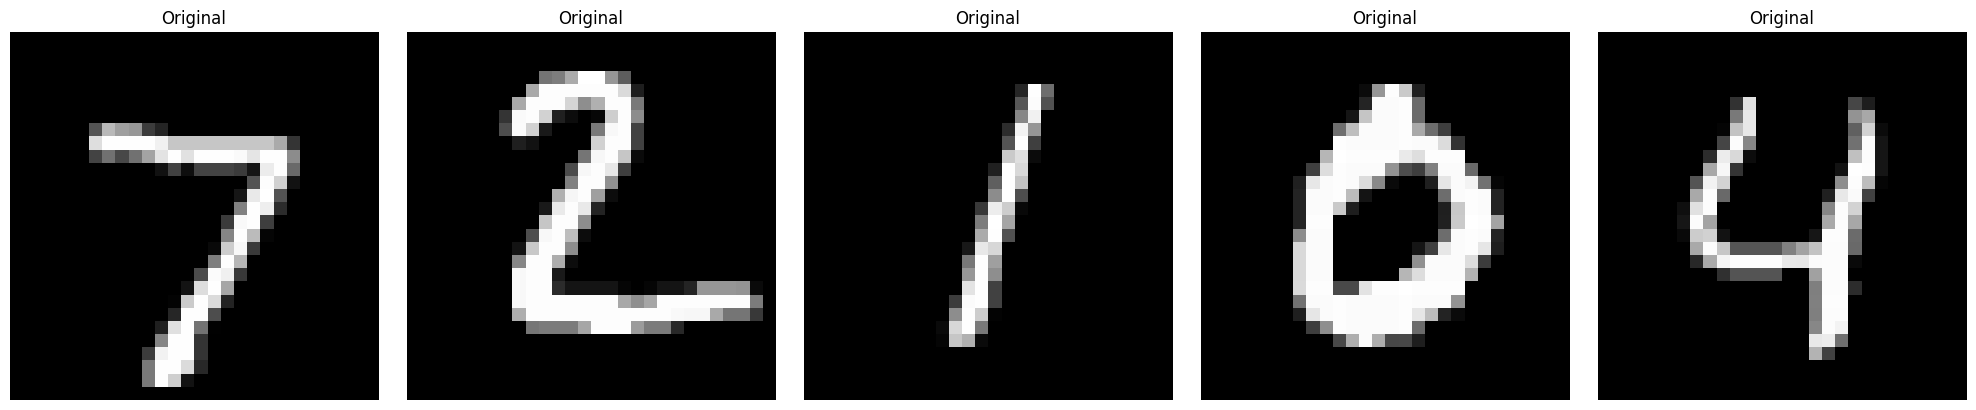

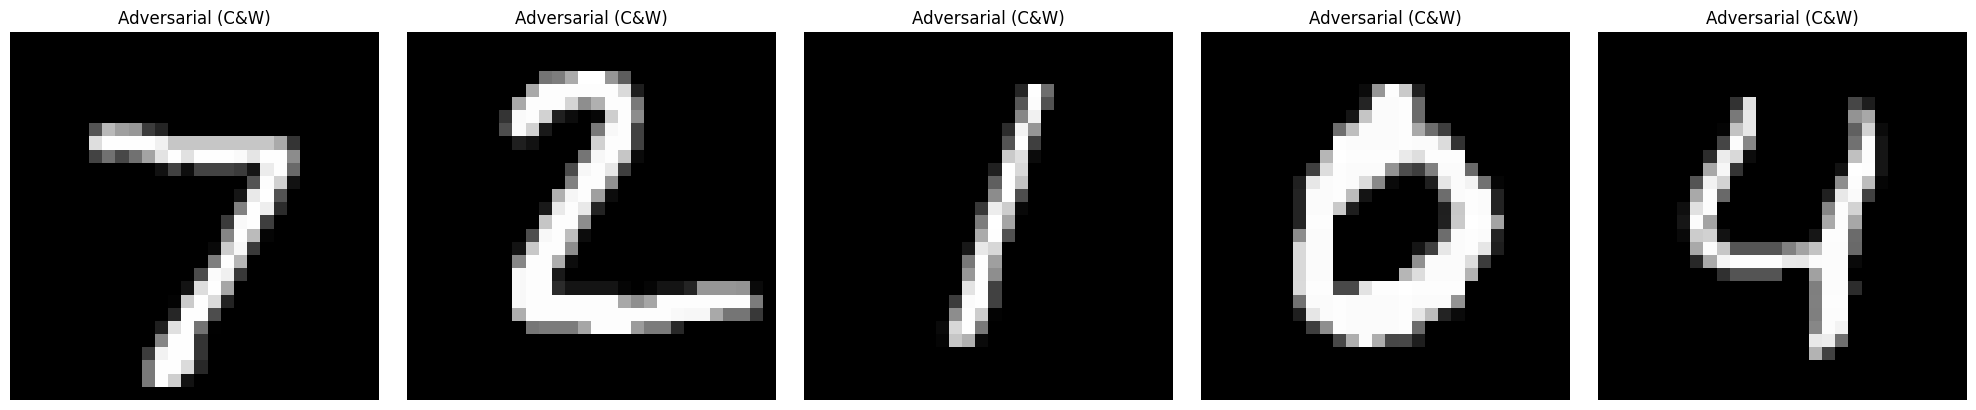

In [37]:
cw = CarliniL2Method(classifier=classifier, targeted=False, max_iter=10, binary_search_steps=1, learning_rate=0.01)
adversarial_samples_cw = cw.generate(x=test_images_original)
adv_predictions = model.predict(adversarial_samples_cw)
titles_cw = ['Adversarial (C&W)' for _ in range(5)]

plot_images(test_images_original[:5], titles_original, 1, 5, (20, 4))
plot_images(adversarial_samples_cw[:5], titles_cw, 1, 5, (20, 4))

#### 3. Vamos a re entrenar con la información generada

In [38]:
train_images_adv = np.concatenate([train_images_original, adversarial_samples_cw])
train_labels_adv = np.concatenate([train_labels_original, test_labels_original[:len(adversarial_samples_cw)]])

model_defense = create_model()
model_defense.fit(train_images_adv, train_labels_adv, epochs=3)

classifier_defense = KerasClassifier(model=model_defense, clip_values=(min_, max_))

adv_trainer = AdversarialTrainer(classifier=classifier_defense, attacks=cw, ratio=1.0)
adv_trainer.fit(x=train_images_adv, y=train_labels_adv, nb_epochs=3)

clean_acc_adv = classifier_defense.predict(x=test_images_original, y=test_labels_original)[1]
adv_acc_adv = classifier_defense.predict(x=adversarial_samples_cw, y=test_labels_original)[1]

print(f"Precisión después del entrenamiento adversarial en datos limpios: {clean_acc_adv}")
print(f"Precisión después del entrenamiento adversarial en datos adversariales: {adv_acc_adv}")

Train on 70000 samples
Epoch 1/3
70000/70000 [==============================] - 77s 1ms/sample - loss: 0.0972 - accuracy: 0.9704
Epoch 2/3
70000/70000 [==============================] - 77s 1ms/sample - loss: 0.0339 - accuracy: 0.9893
Epoch 3/3
70000/70000 [==============================] - 78s 1ms/sample - loss: 0.0213 - accuracy: 0.9936


Adversarial training epochs: 100%|██████████| 3/3 [02:40<00:00, 53.59s/it]


Precisión después del entrenamiento adversarial en datos limpios: [1.0159571e-11 2.4270464e-11 1.0000000e+00 9.7696670e-21 2.3598874e-19
 1.3322958e-22 5.1574454e-16 8.4270696e-18 4.7874302e-16 7.4737208e-18]
Precisión después del entrenamiento adversarial en datos adversariales: [1.0159571e-11 2.4270464e-11 1.0000000e+00 9.7696670e-21 2.3598874e-19
 1.3322958e-22 5.1574454e-16 8.4270696e-18 4.7874302e-16 7.4737208e-18]


#### 4. Defensa del modelo

Primero vamos a aplicar Feature Squeezing

In [39]:
feature_squeezing = FeatureSqueezing(clip_values=(min_, max_), bit_depth=5)
x_test_adv_squeezed, _ = feature_squeezing(adversarial_samples_cw)
adv_predictions_squeezed = model_defense.predict(x_test_adv_squeezed)
adv_acc_squeezed = accuracy_score(np.argmax(test_labels_original, axis=1), np.argmax(adv_predictions_squeezed, axis=1))

print(f"Precisión en datos adversariales después de Feature Squeezing: {adv_acc_squeezed}")


Precisión en datos adversariales después de Feature Squeezing: 1.0


Al aplicar Feature Squeezing a los ejemplos adversariales generados por el ataque Carlini & Wagner (C&W), se obtuvo una precisión en datos adversariales del 100%.

Este resultado indica que Feature Squeezing es extremadamente efectivo para mitigar los efectos del ataque C&W, permitiendo que el modelo clasifique correctamente todos los ejemplos adversariales.

Luego vamos a aplicar Spatial Smoothing

In [40]:
spatial_smoothing = SpatialSmoothing(clip_values=(min_, max_), window_size=3)
x_test_adv_smoothed, _ = spatial_smoothing(adversarial_samples_cw)
adv_predictions_smoothed = model_defense.predict(x_test_adv_smoothed)
adv_acc_smoothed = accuracy_score(np.argmax(test_labels_original, axis=1), np.argmax(adv_predictions_smoothed, axis=1))

print(f"Precisión en datos adversariales después de Spatial Smoothing: {adv_acc_smoothed}")

Precisión en datos adversariales después de Spatial Smoothing: 0.995


Este resultado muestra que Spatial Smoothing también es muy eficaz en reducir el impacto de perturbaciones adversariales generadas por C&W, permitiendo al modelo mantener una alta precisión en la clasificación de ejemplos adversariales.